In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-16


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import os
import matplotlib
import math
import seaborn as sns

import lib.minibulk_funcs as mb
import lib.figs_funcs as figfunc
import lib.matx_funcs as matxfunc
import lib.fun_plotting as fun_plotting
import lib.funcs_ko as funcs_ko
import lib.NetAnalysis as na
import lib.funcs_general as funcs_general

%load_ext autoreload
%autoreload 2

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [4]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"

In [5]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")
imp_genes

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Tcf7l1',
       'Nanog', 'Sall4', 'Pou5f1', 'Sox2', 'Dnmt3a', 'Dnmt3b', 'Utf1',
       'Otx2', 'Etv5', 'Etv4', 'Nr0b1', 'Zic3', 'Lef1', 'Tcf15', 'Gbx2',
       'Pou3f1', 'Rbpj'], dtype='<U7')

In [6]:
# GENE CLASSIFICATION
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))

Fissiamo la threshold per calcolare il Mini-bulk

In [7]:
mb_wind = 150

# Check

In [8]:
def TP_check(interaction_list, interaction_matrix, genes_list, inferred_int_thr = 0, Norm = True):
    """
    NOTE: for not symmetric interaction_matrix:
    - rows: who undergoes the action;
    -columns: who acts.
    NOTE: to read the input interaction_list:
    - couple[0] : who acts;
    - couple[1] : who undergoes the action.
    
    NOTE: inferred_int_thr is computed as fraction of max(interaction_matrix) 
    """
    if Norm:
        m_max = np.max(np.abs(interaction_matrix))
    else:
        m_max = 1
    
    true_positive=0
    int_val = np.zeros(len(interaction_list))
    wrong_ints = []
    out_matx = np.zeros((4, len(interaction_list)))
    
    for ii in range(len(interaction_list)): # split the list of strings
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0  
        
        # check if the interaction's genes already exist:
        if (len(np.where(genes_list == couple[0])[0])==0):
            print("Gene "+ couple[0]+" not found")
            continue
        if (len(np.where(genes_list == couple[1])[0])==0):
            print("Gene "+ couple[1]+" not found")
            continue
            
        # the subjects of the interaction
        out_matx[0,ii] = gene0_idx # who acts
        out_matx[1,ii] = gene1_idx # who acts
  
        # the interaction value (and the sign of the interaction)
        out_matx[2,ii] = interaction_matrix[gene1_idx[0], gene0_idx[0]]
        interaction = np.sign(out_matx[2,ii])

        if (interaction==int(couple[2])) and (np.abs(out_matx[2,ii])/m_max >= inferred_int_thr):
            out_matx[3,ii] = 1
        else:
            out_matx[3,ii] = 0

    return(np.sum(out_matx[3,:])/len(out_matx[3,:]), out_matx)
        

In [9]:
def TP_plot(interaction_list, interaction_matrix, genes_order, inferred_int_thr=0, Norm_Matx = False,
            data_type="scRNA-seq PST MB", 
            figplot=True, nbin=30, 
            verbose=False, Norm=True):
    """Wrap function to visualize all the results of the comparison with the known interactions (TP)"""
    
    if Norm_Matx:
        interaction_matrix= interaction_matrix/np.nanmax(np.abs(interaction_matrix))

    # Check the list of known interactions correctly inferred
    TP_fraction, TP_info = TP_check(interaction_list, interaction_matrix, genes_order, inferred_int_thr, Norm=Norm)
    
    # Print the fraction of true positives and the TP and all interaction values:
    if verbose==True:
        print("\nRESULTS for " + data_type)
        print("\nTP fraction:", np.round(TP_fraction, 2))
        print("\nInteraction values:\n", np.round(TP_info[2,:],3))
        print("\nTP ints values:\n", np.round(TP_info[2,:]*TP_info[3,:],3))
    
    # If the figplot flag is set to True, plot the matrix and the distribution of the INTERACTION MATRIX
    if figplot==True:
        bins = np.linspace(interaction_matrix.flatten().min(), interaction_matrix.flatten().max(), nbin)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        figfunc.plotmat(interaction_matrix, fig, ax[0], genes_order, data_type+"")
        sns.histplot(np.ndarray.flatten(interaction_matrix), ax=ax[1], stat="density", bins=bins)
        plt.show()
        
    return(TP_fraction, TP_info, interaction_matrix)


## Neighbours Interactions

In [10]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", # "Stat3 Stat3 1"
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [11]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

# SCODE

## PST

Min pseudotime:  0.0 - Max pseudotime:  26.2993780102351
Number of cells in PST df:  9732
              barcodes time        pst
9156  TTCAGGAAGCAGTACG  00h   0.000000
6252  GTAGATCAGTAGGTTA  00h   0.303601
3486  CGAAGGACACGGGCTT  00h   0.409823
6441  GTCGCGAGTCGTCTCT  00h   0.492022
3460  CCTTCAGGTCCAGCGT  00h   0.550231
...                ...  ...        ...
5202  GATTCGAAGATACAGT  24h  26.014790
5406  GCCAGGTAGAAGAACG  48h  26.075457
3834  CGTGCTTTCGACGTCG  48h  26.133877
1471  AGGGTGACAATACGAA  48h  26.139080
3016  CCACAAAAGCGTGAAC  48h  26.299378

[8273 rows x 3 columns]


/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_140/777795941.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_140/777795941.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_140/777795941.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)


(8273, 3)

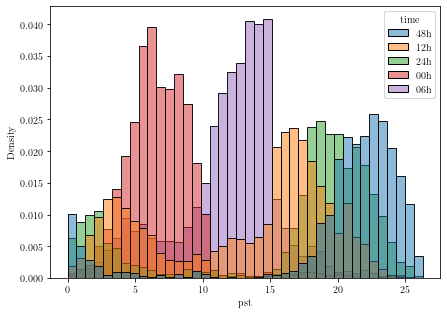

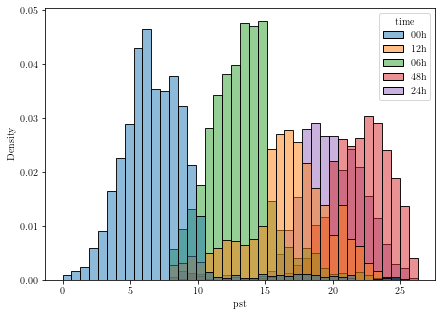

In [12]:
PST_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_UMAPno2clcs_23_01_13.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

print("Min pseudotime: ", np.min(PST_df["pst"]), "- Max pseudotime: ", np.max(PST_df["pst"]))
print("Number of cells in PST df: ", PST_df.shape[0])

# sorting in ascending values of pseudo-time
PST_df = PST_df.sort_values(by=['pst'])
PST_df.tail(3)

# PLOT different times separated
plt.figure(figsize=(7,5))
sns.histplot(data=PST_df, x="pst", hue="time", stat="density", bins=40)

PST_df_new = PST_df.drop(PST_df[(PST_df["time"] == "48h") & (PST_df["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)
# PST_df_new = PST_df_new.drop(PST_df_new[(PST_df_new["pst"] < 3.00)].index)

print(PST_df_new)

plt.figure(figsize=(7,5))
sns.histplot(data=PST_df_new, x="pst", hue="time", stat="density", bins=40)

pst_df = PST_df_new.copy()
pst_df.shape

In [13]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
# df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")



column_names = pst_df["barcodes"]
df_pN_pst = df_pN_pst.reindex(columns = column_names)

df_pN_pst.head(3)
df_pN_pst.shape

(24, 8273)

### Initial vector for SIMULATION

In [14]:
# # Creating a column of integers from 0 to the length of the series
# df_saving_index = pd.DataFrame(range(len(genes_order))).set_index(genes_order)

# # concatenating the series and the index
# result = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:1000].mean(axis=1)], axis=1)
# result
# # Saving the resulting DataFrame as a tab-separated text file named 'result.txt'
# result.to_csv(path_data+"OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt", sep='\t', index=False, header=False)


In [15]:
data_LN = df_pN_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)
print(data_LN.shape)

(24, 8273)


In [16]:
data_PST= pst_df.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes

#normalize pst between 0 and 1
data_PST["pst"]=data_PST["pst"]/(data_PST["pst"].max())

data_PST["time"] = data_PST["time"].astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print(data_PST.shape)
data_PST.head(5)




(8273, 2)


,time,pst
0,0,0.000000
1,0,0.011544
2,0,0.015583
3,0,0.018708
4,0,0.020922


## Check on RSS (100 trials)

In [17]:
# Train and Test
training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

# print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


(24, 6618) (24, 1655)
(6618, 2) (1655, 2)


In [18]:
saving = False
# save as txt training_data and test_data
if saving:
    pd.DataFrame.to_csv(training_data, path_data+"OUT_SCODE_PN/PST/TO_COMP/train_data.txt", sep='\t', index=None, header=None)
    pd.DataFrame.to_csv(testing_data, path_data+"OUT_SCODE_PN/PST/TO_COMP/test_data.txt", sep='\t', index=None, header=None)
    pd.DataFrame.to_csv(training_time, path_data+"OUT_SCODE_PN/PST/TO_COMP/train_time.txt", sep='\t', index=None, header=None)
    pd.DataFrame.to_csv(testing_time, path_data+"OUT_SCODE_PN/PST/TO_COMP/test_time.txt", sep='\t', index=None, header=None)

# Matrices computation

In [19]:
# # path1 =  path+"1_NetworkInference/"

# # Train part with more executions
# genes = 24
# D = [2,3,4,6,8]
# cells_train = 6618
# cells_test = 1655
# iters = 100
# Nexp=100

# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         print("Exp ", ii)
#         out=path_data+"OUT_SCODE_PN/PST/out_z"+str(D[jj])+"/exp_"+str(ii)
#         print(out)
#         # Train
#         ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/PST/TO_COMP/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/PST/TO_COMP/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
#         # Test
#         out_file = path_data+"OUT_SCODE_PN/PST/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/PST/TO_COMP/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/PST/TO_COMP/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# From Here to not recompute ALL

In [20]:
# # Compute D quantile
# genes = 24
# D = [2,4,6,8]
# cells_train = 6499
# cells_test = 1625
# iters = 100
# data_GE  = training_data
# data_PST = training_time
# Nexp=100

# RSS_vect = np.zeros((len(D), Nexp))
# RSS_quantile = np.zeros((3,len(D)))

# # TP_vect = np.zeros((len(D),Nexp))
# # TP_max = np.zeros(len(D))
# # A_tot = np.zeros((genes, genes, len(D)))
# # A_mean = np.zeros((genes, genes, len(D)))
# A_sample = np.zeros((genes, genes, len(D), Nexp))
# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         out=       path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
#         out_file = path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
# #         print(D[jj], ii, RSS_vect[jj,ii])
#         A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
# #         A_tot[:,:,jj] += locals()["A"+str(ii)]
# #     A_mean = A_tot[:,:,jj]/Nexp
        
#     RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])
# #     TP_max[jj] = TP_vect[jj,:].max()

# Compute D quantile
genes = 24
D = [2,4,6,8]
cells_train = 6499
cells_test = 1625
iters = 100
data_GE  = training_data
data_PST = training_time
Nexp=100

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

# TP_vect = np.zeros((len(D),Nexp))
# TP_max = np.zeros(len(D))
# A_tot = np.zeros((genes, genes, len(D)))
# A_mean = np.zeros((genes, genes, len(D)))
A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       path_data+"OUT_SCODE_PN/PST/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = path_data+"OUT_SCODE_PN/PST/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
#         print(D[jj], ii, RSS_vect[jj,ii])
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
#         A_tot[:,:,jj] += locals()["A"+str(ii)]
#     A_mean = A_tot[:,:,jj]/Nexp
        
    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])
#     TP_max[jj] = TP_vect[jj,:].max()



D:  2
D:  4
D:  6
D:  8


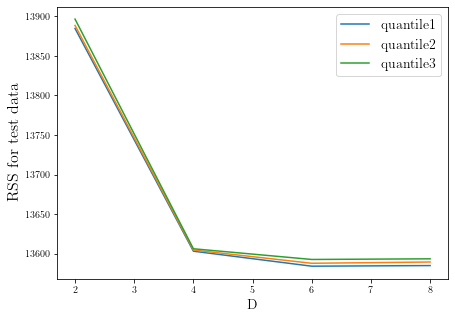

In [21]:
plt.figure(figsize=(7,5))
for ii in range(RSS_quantile.shape[0]):
    plt.plot(D, RSS_quantile[ii,:], label="quantile"+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("RSS for test data", fontsize=16)
    plt.xlabel("D", fontsize=14)    

In [22]:
# Per OGNI D: Devo riordinare in ordine crescente di RSS e poi prendere i 50 RSS più piccoli
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    for ii in range(len(idx)):
        A_sel[:,:,jj,ii] = A_sample[:,:,jj,idx[ii]]
        A_lin[:,jj,ii] = A_sample[:,:,jj,idx[ii]].flatten()
        
    


In [23]:
A_lin.shape

(576, 4, 50)

In [24]:
A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
#     print(np.quantile(A_exp_corr, 0.25))
    A_quantile[:,jj] = np.array([np.quantile(A_exp_corr, 0.25), np.quantile(A_exp_corr, 0.5), np.quantile(A_exp_corr, 0.75)])


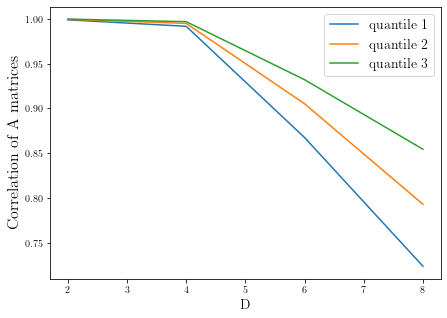

In [25]:
plt.figure(figsize=(7,5))
for ii in range(A_quantile.shape[0]):
    plt.plot(D, A_quantile[ii,:], label="quantile "+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("Correlation of A matrices", fontsize=16)
    plt.xlabel("D", fontsize=14) 

# Inferred Matrix with D=4

In [29]:
DD = 1
print("D=", D[DD])

sel_thr = 0.02
print("thr=", sel_thr)

D= 4
thr= 0.02


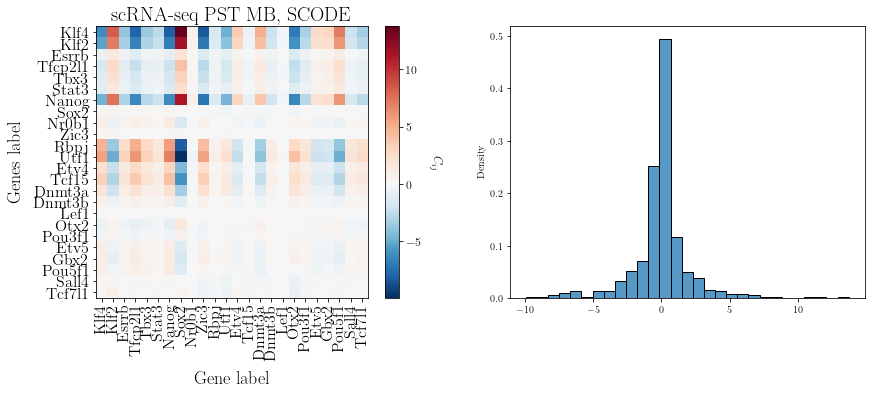

TP fraction  0.5555555555555556
Not Normalized TRUE interactions [-0.   -0.    0.   -0.86 -0.35  0.32 -0.   -0.    1.82 -0.43 -2.86 -2.69
  0.   -0.96 -1.44 -0.46  0.    0.  ]
Normalized TRUE interactions [-0.   -0.    0.   -0.06 -0.03  0.02 -0.   -0.    0.13 -0.03 -0.21 -0.2
  0.   -0.07 -0.1  -0.03  0.    0.  ]
Not Normalized interactions [-2.57 -0.89  0.24 -0.86 -0.35  0.32 -0.76 -0.19  1.82 -0.43 -2.86 -2.69
  0.41 -0.96 -1.44 -0.46  0.02  0.14]
Normalized interactions [-0.19 -0.06  0.02 -0.06 -0.03  0.02 -0.06 -0.01  0.13 -0.03 -0.21 -0.2
  0.03 -0.07 -0.1  -0.03  0.    0.01]


In [30]:
N_sel_A = 50
A_tot = np.sum(A_sel[:,:,DD,:N_sel_A], axis=2 )/N_sel_A
        

TP_fraction, TP_info, interaction_matrix = funcs_general.TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=sel_thr, 
                                                   Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
                                                   figplot=True, nbin=30, 
                                                    verbose=False, Norm=True)
                                        
                                                   
                                                    
print("TP fraction ", TP_fraction)
# result = TP_info[2,:]*TP_info[3,:]
# non_zero_values = result[np.nonzero(result)]
# print(np.nanmin(np.abs(non_zero_values)))

print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

print("Not Normalized interactions", np.round(TP_info[2,:],2))
print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))


### Fraction of discarded

In [28]:
high_meanMatx_thr = na.to_thr_matrix(A_tot, thr=sel_thr)
print(1-(len(np.where(high_meanMatx_thr==0)[0]))/(24**2))
print(len(np.where(A_tot==0)[0]))

0.7534722222222222
0


In [48]:
np.savetxt(path_data+"OUT_SCODE_PN/A_sel_PsiNorm.txt",A_tot)

# FIN QUI

# Simulation

In [45]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [34]:
compute = False
N_sim=500
df_sim = np.zeros((len(genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/NO_KO/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/A_sel_PsiNorm_MB.txt {out_sim} {24}

    # load simulated data
    df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/NO_KO/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(genes_order)
    df_sim[df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [35]:
# simulating WT
df_sim_avg, df_sim_std = funcs_ko.WT_avg_w(df_sim)
df_sim_std = (df_sim.std(axis=1)/np.sqrt(df_sim.shape[1]))[:,0]

# experimental WT
df_avg = data_LN.mean(axis=1)
df_std = data_LN.std(axis=1)/np.sqrt(data_LN.shape[1])

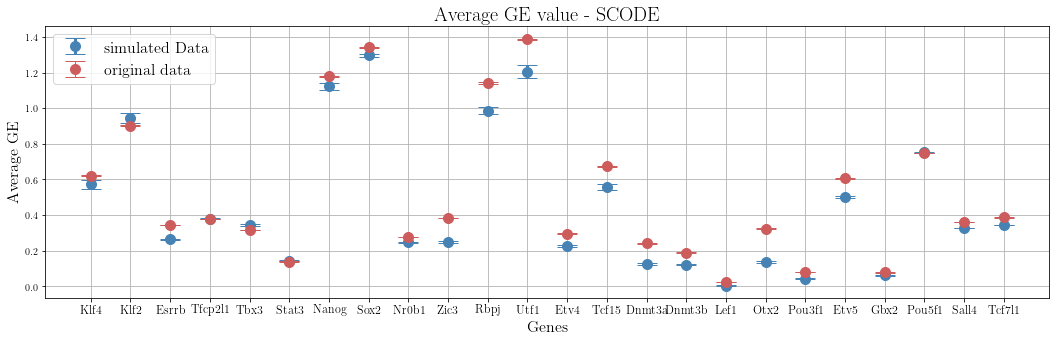

In [36]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, df_sim_avg, yerr=df_sim_std,  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, df_avg, yerr=df_std, 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average GE", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average GE value - SCODE", fontsize=20)
plt.grid(True)

gene:  Klf4  has a difference of:  -0.0485257880510348  std:  0.07332298291837204
gene:  Klf2  has a difference of:  0.0437562671334496  std:  0.08401774248632102
gene:  Tfcp2l1  has a difference of:  0.001469417161350628  std:  0.012229656166947434
gene:  Stat3  has a difference of:  0.004063941025939738  std:  0.007170063341395239
gene:  Nanog  has a difference of:  -0.05591390611058178  std:  0.06016036220540129
gene:  Pou5f1  has a difference of:  0.0016255229445708563  std:  0.014842799875998326
fraction of significant 0.25


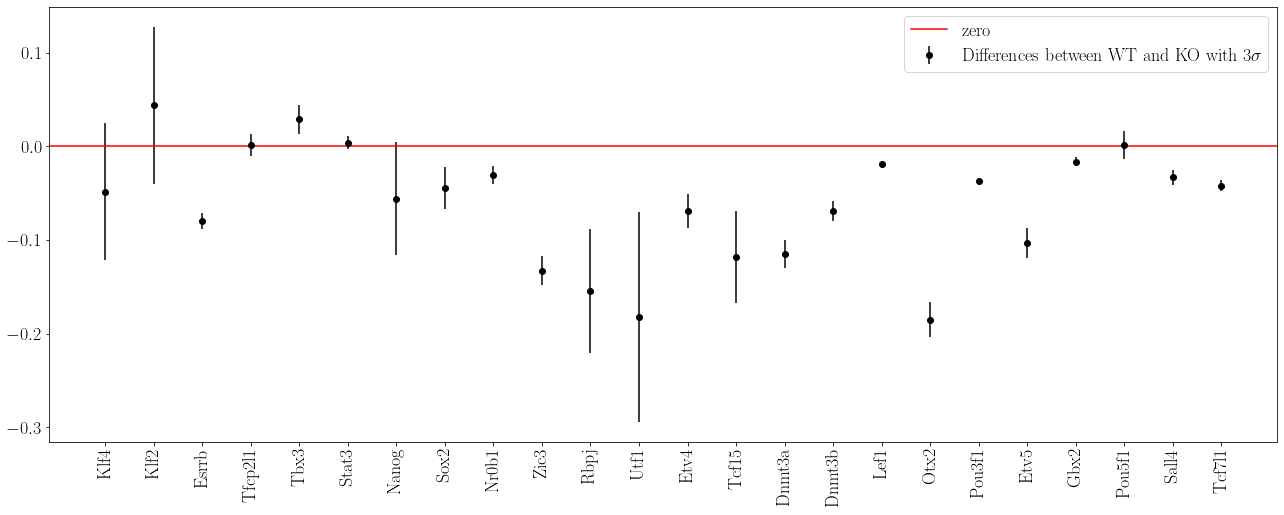

In [37]:
# number of sigma considered
N_sigma = 3

# compute the difference between the original and simulated spins values
diff_activity_pN = np.zeros(len(genes_order))
diff_activity_pN_std = np.zeros(len(genes_order))
count = 0
for i in range(len(genes_order)):
    diff_activity_pN[i] = (df_sim_avg[i] - df_avg[i])
    diff_activity_pN_std[i] = np.sqrt(df_sim_std[i]**2 + df_std[i]**2)
    if np.abs(diff_activity_pN[i]) < N_sigma * diff_activity_pN_std[i]:
        print("gene: ", genes_order[i], " has a difference of: ", diff_activity_pN[i], " std: ", N_sigma * diff_activity_pN_std[i])
        count += 1

plt.figure(figsize=(22,8))
plt.errorbar(genes_order, diff_activity_pN, yerr=N_sigma*diff_activity_pN_std, fmt='o', color='black', label = "Differences between WT and KO with "+str(N_sigma)+"$\sigma$")
plt.axhline(y=0, color='r', linestyle='-', label= " zero")
plt.legend(fontsize=18, loc="upper right")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)

print("fraction of significant", count/len(genes_order))

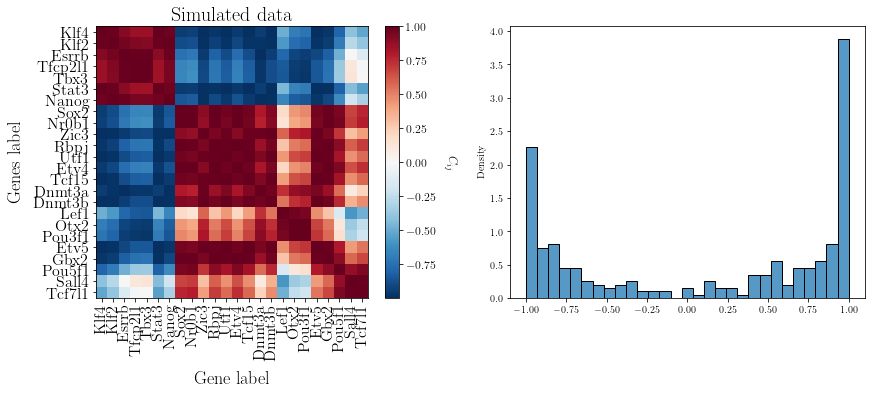

In [38]:
cm_sim = np.zeros((df_sim.shape[0], df_sim.shape[0], df_sim.shape[2]))
for ii in range(df_sim.shape[2]):
    cm_sim[:,:, ii] = np.corrcoef(df_sim[:,:,ii])
cm_sim_SCODE_PST_MB_pN_Cont = np.mean(cm_sim, axis=2)
# cm_sim_SCODE_PST_MB_pN_Cont = np.corrcoef(df_sim)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_pN_Cont, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_pN_Cont), bins=bins,  ax=ax[1], stat="density")
plt.show()

# # plt.imshow(np.corrcoef(spins_new_lN))
# print(np.where(spins_sim==float("nan")))



## Original CM

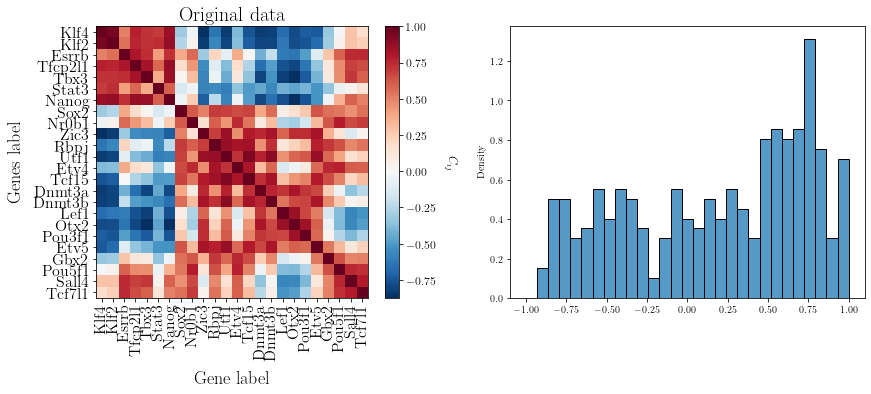

In [39]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_pst_mb_psiNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

### Distance

In [40]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [41]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=500
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) ########################
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long

corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])


In [42]:
noise_dist = [sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(Ntest)]

noise_dist = np.mean(noise_dist)

result_SO = sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE_PST_MB_pN_Cont)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


Scode - Orig 0.82


In [43]:
# np.savetxt('cm_sim_SCODE_MB_PsiNorm.txt', cm_sim_SCODE_PST_MB_pN_Cont)

# KO

In [44]:
def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[ii,:]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)


In [45]:
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_order):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_order)
    plt.axhline(0)
    plt.legend()

## Rpbj

In [46]:
# get the initial gene expression and the KO interaction matrix to simulate the KO data
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_R_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_R_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)



In [47]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (9,)


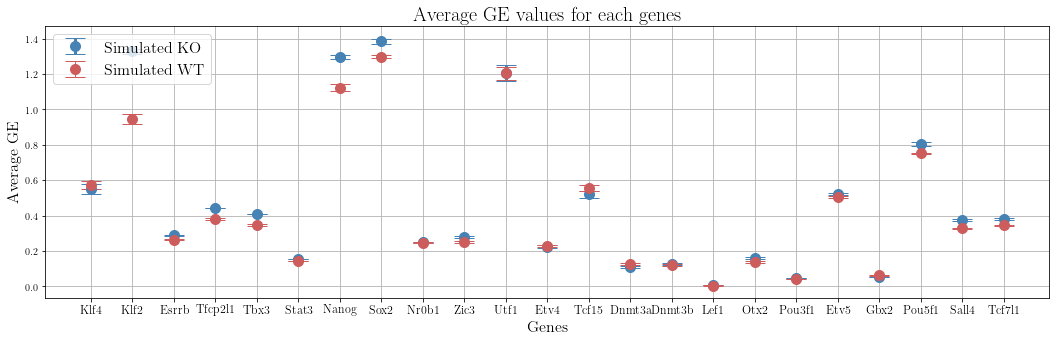

In [48]:
# compute the average and std of the simulated  KO data
KO_R_df_sim_avg, KO_R_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_R_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_R_diff, KO_R_diff_std, KO_R_idx_notS = funcs_ko.KO_diff_sim(KO_R_df_sim_avg, KO_R_df_sim_std ,KO_R_wt_avg, KO_R_wt_std, thr_significance=3)
# print("differences in the simulated data", KO_R_diff)
# print("error in the simulated data", KO_R_diff_std)
print("index of genes not significantly different", KO_R_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_R_df_sim_avg, KO_R_df_sim_std, KO_R_wt_avg, KO_R_wt_std, KO_genes_order, N_sigma=1)

[ 0  8 10 11 12 13 14 17 18]
KO_std-wt_std not significant for gene  ['Klf4' 'Nr0b1' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Pou3f1' 'Etv5'] [ 0  8 10 11 12 13 14 17 18]
in agreement 0.8
data considered 5
considered genes ['Esrrb' 'Tfcp2l1' 'Tbx3' 'Nanog' 'Lef1']


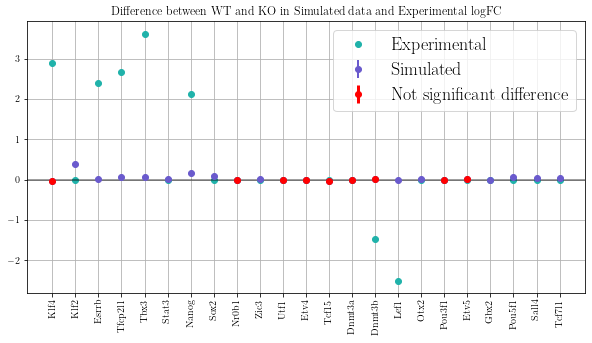

In [49]:
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_pN_R, data_considered_pN_R, considered_genes_pN_R = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_R, KO_R_diff, KO_R_diff_std, KO_genes_order)
print("in agreement", in_agreement_pN_R)
print("data considered", data_considered_pN_R)
print("considered genes", considered_genes_pN_R)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_R, KO_R_diff, KO_R_diff_std, KO_genes_order, KO_R_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


## Etv5

In [50]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_E_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_E_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [51]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute == True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (20,)


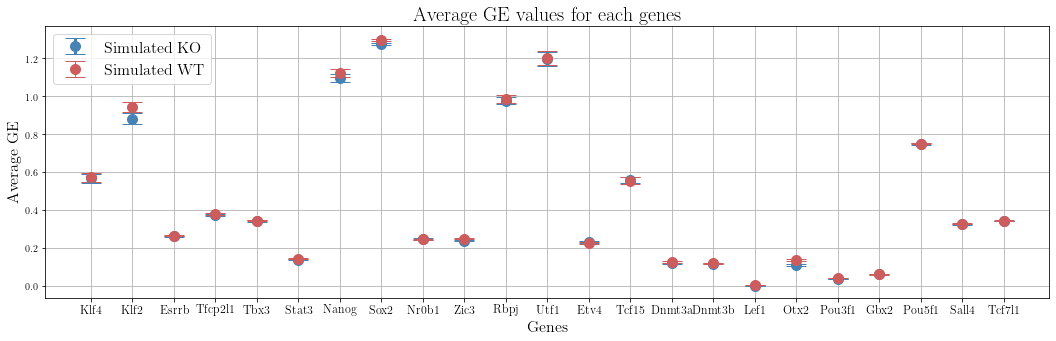

In [52]:
# compute the average and std of the simulated  KO data
KO_E_df_sim_avg, KO_E_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_E_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


KO_E_diff, KO_E_diff_std, KO_E_idx_notS = funcs_ko.KO_diff_sim(KO_E_df_sim_avg, KO_E_df_sim_std ,KO_E_wt_avg, KO_E_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_E_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_E_df_sim_avg, KO_E_df_sim_std, KO_E_wt_avg, KO_E_wt_std, KO_genes_order, N_sigma=1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22]
KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Rbpj' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Gbx2' 'Pou5f1'
 'Sall4' 'Tcf7l1'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22]
in agreement 1.0
data considered 1
considered genes ['Lef1']


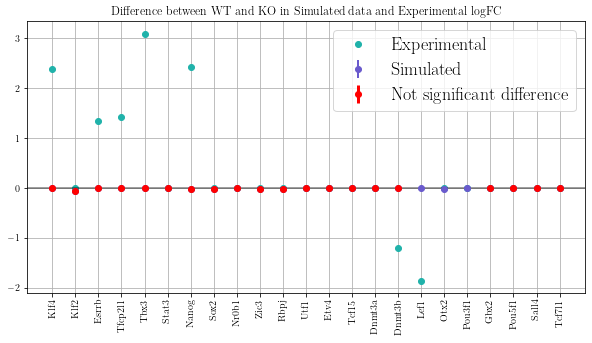

In [53]:
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_pN_E, data_considered_pN_E, considered_genes_pN_E = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_E, KO_E_diff, KO_E_diff_std, KO_genes_order)
print("in agreement", in_agreement_pN_E)
print("data considered", data_considered_pN_E)
print("considered genes", considered_genes_pN_E)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_E, KO_E_diff, KO_E_diff_std, KO_genes_order, KO_E_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


## Tcf7l1

In [54]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_T_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_T_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)


In [55]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


index of genes not significantly different (23,)


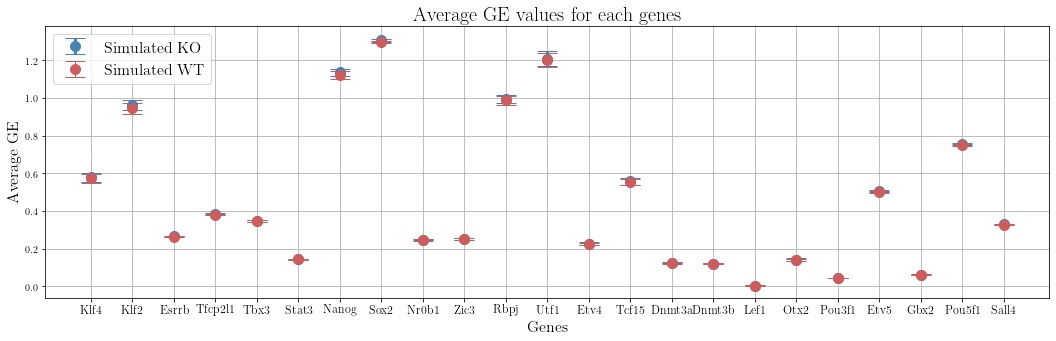

In [56]:
# compute the average and std of the simulated  KO data
KO_T_df_sim_avg, KO_T_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_T_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_T_diff, KO_T_diff_std, KO_T_idx_notS = funcs_ko.KO_diff_sim(KO_T_df_sim_avg, KO_T_df_sim_std ,KO_T_wt_avg, KO_T_wt_std, thr_significance=3)

print("index of genes not significantly different", KO_T_idx_notS.shape)

funcs_ko.KO_plots_avgAct_SCODE(KO_T_df_sim_avg, KO_T_df_sim_std, KO_T_wt_avg, KO_T_wt_std, KO_genes_order, N_sigma=1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Rbpj' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2'
 'Pou3f1' 'Etv5' 'Gbx2' 'Pou5f1' 'Sall4'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
in agreement 0
data considered 0
considered genes []


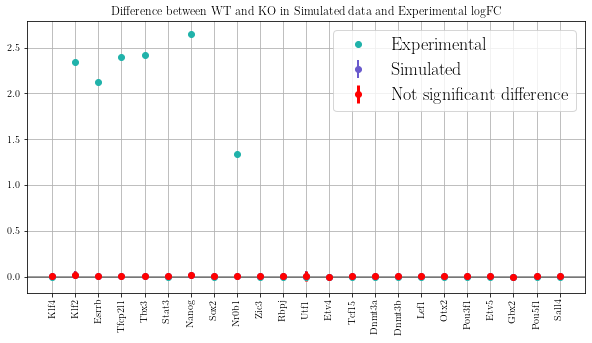

In [57]:
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


in_agreement_pN_T, data_considered_pN_T, considered_genes_pN_T = funcs_ko.KO_diff_ExpVsSim(logFC_Leeb_T, KO_T_diff, KO_T_diff_std, KO_genes_order)
print("in agreement", in_agreement_pN_T)
print("data considered", data_considered_pN_T)
print("considered genes", considered_genes_pN_T)

funcs_ko.KO_plof_Diff_LogFC(logFC_Leeb_T, KO_T_diff, KO_T_diff_std, KO_genes_order, KO_T_idx_notS, 'Difference between WT and KO in Simulated data and Experimental logFC')


# Three KO

In [58]:
KO_gene = ["Rbpj", "Etv5", "Tcf7l1"]
KO_gene_idk = [np.where(genes_order == KO_gene[i])[0][0]  for i in range(len(KO_gene))]


KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)

KO_Th_wt_avg = np.delete(np.array(df_sim_avg),KO_gene_idk, axis=0)
KO_Th_wt_std = np.delete(np.array(df_sim_std),KO_gene_idk, axis=0)

In [59]:
compute = False
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))
for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    if compute==True:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt {out_sim} {21}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    


Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [60]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]


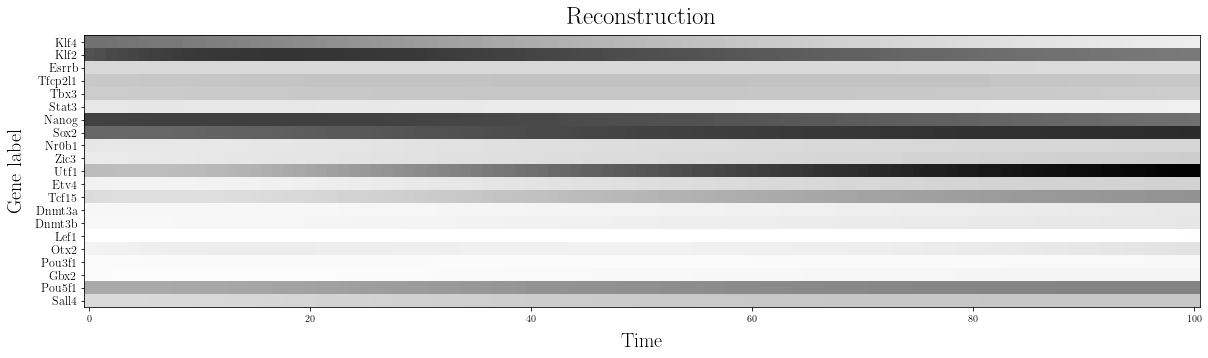

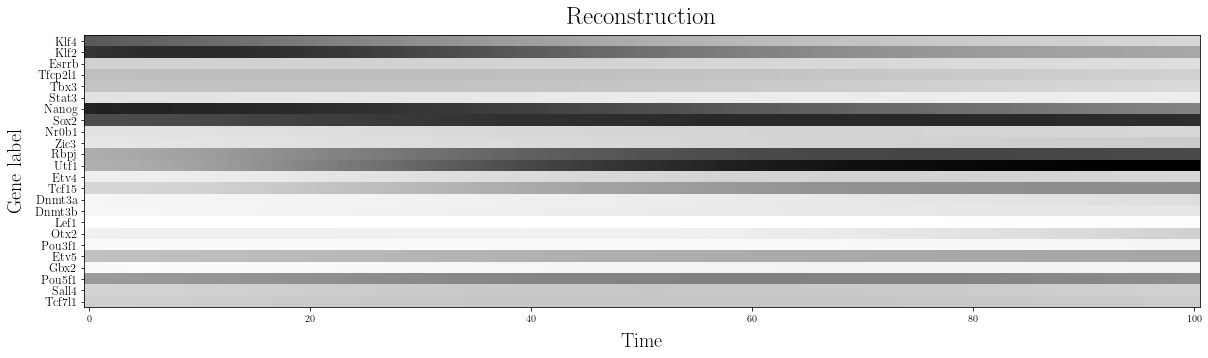

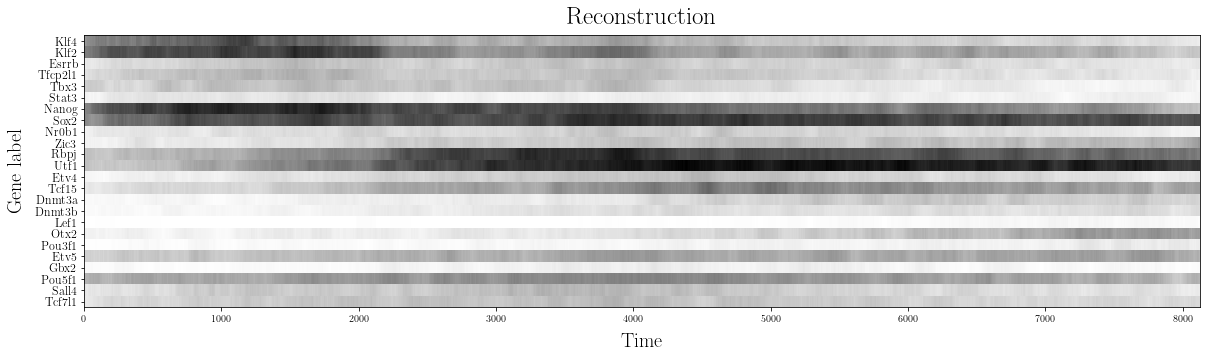

In [61]:
fun_plotting.raster_plot(KO_df_sim[:,:,0], 'Reconstruction', 1, KO_genes_order)
plt.show()

fun_plotting.raster_plot(df_sim[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()

fun_plotting.raster_plot(np.array(df_lN_mb_pst), 'Reconstruction', 1, genes_order)
plt.show()

index of genes not significantly different [ 0  5  8  9 10 11 12 14 15 16 17 18]
number of genes significantly different (9,)
['Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Nanog' 'Sox2' 'Dnmt3a' 'Pou5f1' 'Sall4']


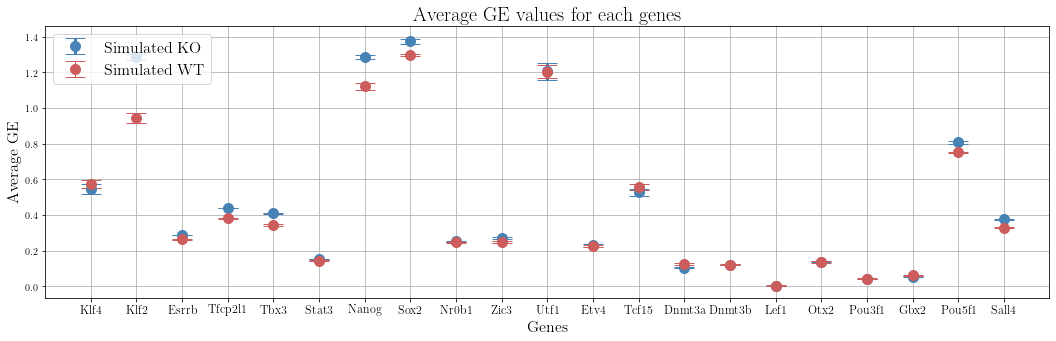

In [62]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg, KO_Th_df_sim_std = funcs_ko.WT_avg_w(KO_df_sim)
KO_Th_df_sim_std = (np.std(KO_df_sim, axis=1)/np.sqrt(KO_df_sim.shape[1]))[:,0]

KO_Th_diff, KO_Th_diff_std, KO_Th_idx_notS = funcs_ko.KO_diff_sim(KO_Th_df_sim_avg, KO_Th_df_sim_std ,KO_Th_wt_avg, KO_Th_wt_std, thr_significance=3)
# KO_Th_genes_order_sel = KO_genes_order[KO_Th_idx_notS]
KO_Th_genes_order_sel = np.delete(KO_genes_order, KO_Th_idx_notS, axis=0)

print("index of genes not significantly different", KO_Th_idx_notS)
print("number of genes significantly different", KO_Th_genes_order_sel.shape)
# print(KO_genes_order)
print(KO_Th_genes_order_sel)

funcs_ko.KO_plots_avgAct_SCODE(KO_Th_df_sim_avg, KO_Th_df_sim_std, KO_Th_wt_avg, KO_Th_wt_std, KO_genes_order, N_sigma=1)



number of experimental data, no KO (17, 1)


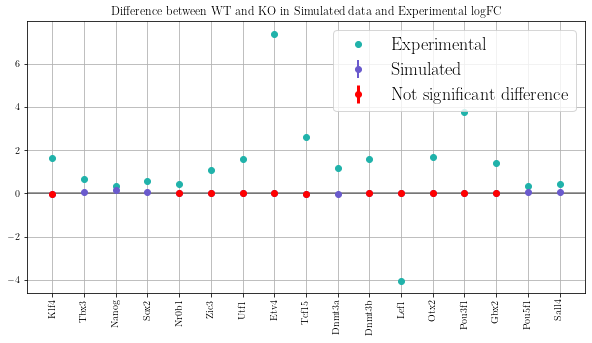

In [63]:
# exp logFC
df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO.csv', index_col=0, header=0)

# # remove row of the KO
df_tKO_Kalkan_sel = df_tKO_Kalkan.drop(["Etv5", "Tcf7l1"])
print("number of experimental data, no KO",df_tKO_Kalkan_sel.shape)

# select only the genes present in df_tKO_Kalkan_sel
KO_Th_diff_temp = KO_Th_diff[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_Th_diff_std_temp = KO_Th_diff_std[np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])]
KO_genes_order_temp = np.array([x for x in KO_genes_order if x in df_tKO_Kalkan_sel.index])
KO_genes_order_temp_idx = np.array([x for x in range(len(KO_genes_order)) if KO_genes_order[x] in df_tKO_Kalkan_sel.index])
# select only indices KO_Th_idx_notS present in KO_genes_order_temp
sel_idxs_KO = np.intersect1d(KO_genes_order_temp, KO_genes_order[KO_Th_idx_notS])
sel_idxs_KO = np.array([x for x in range(len(df_tKO_Kalkan_sel.index)) if df_tKO_Kalkan_sel.index[x] in sel_idxs_KO])
funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, KO_Th_diff_temp, KO_Th_diff_std_temp, KO_genes_order_temp, sel_idxs_KO, 'Difference between WT and KO in Simulated data and Experimental logFC')

KO_Th_diff = np.delete(KO_Th_diff, KO_Th_idx_notS, axis=0)
KO_Th_diff_std = np.delete(KO_Th_diff_std, KO_Th_idx_notS, axis=0)
# search gene present in genes_order and absent in df_tKO_Kalkan
common_genes = np.array([x for x in KO_Th_genes_order_sel if x in df_tKO_Kalkan_sel.index])

# indices of genes_order corresponding to common_genes
common_genes_idx = np.array([x for x in range(len(KO_Th_genes_order_sel)) if KO_Th_genes_order_sel[x] in df_tKO_Kalkan_sel.index])

# select only simulated KO and WT for which we know experimental tKO
# differences for the considered genes
KO_Th_diff_sel = KO_Th_diff[common_genes_idx]
KO_Th_diff_std_sel = KO_Th_diff_std[common_genes_idx]

df_tKO_Kalkan_sel = df_tKO_Kalkan_sel.loc[common_genes]
df_tKO_Kalkan_sel = np.squeeze(np.array(df_tKO_Kalkan_sel.iloc[:,0]))

[]
KO_std-wt_std not significant for gene  [] []
in agreement 0.8333333333333334
data considered 6
considered genes ['Tbx3' 'Nanog' 'Sox2' 'Dnmt3a' 'Pou5f1' 'Sall4']


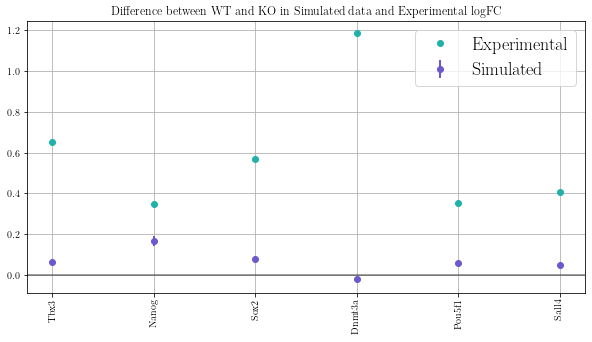

In [64]:

in_agreement_pN_T, data_considered_pN_T, considered_genes_pN_T = funcs_ko.KO_diff_ExpVsSim(df_tKO_Kalkan_sel, KO_Th_diff_sel, KO_Th_diff_std_sel, common_genes)
print("in agreement", in_agreement_pN_T)
print("data considered", data_considered_pN_T)
print("considered genes", considered_genes_pN_T)

funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, KO_Th_diff_sel, KO_Th_diff_std_sel, common_genes, [], 'Difference between WT and KO in Simulated data and Experimental logFC')

